# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


### Contents:
- [Background](#Background)
- [Data](#Data)



In [2]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import utils
pd.options.mode.chained_assignment = None  # default='warn'

import torch
tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

### Training set


**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [ ]:
# /content/drive/MyDrive/Colab Notebooks/data

In [ ]:
# labels_train_abnormal = pd.read_csv('../data/train-abnormal.csv', names=['nr','abnormal'])
# labels_train_meniscus = pd.read_csv('../data/train-meniscus.csv', names=['nr','meniscus'])
# labels_train_acl = pd.read_csv('../data/train-acl.csv', names=['nr','acl'])

In [ ]:
# labels_valid_abnormal = pd.read_csv('../data/valid-abnormal.csv', names=['nr','abnormal'])
# labels_valid_meniscus = pd.read_csv('../data/valid-meniscus.csv', names=['nr','meniscus'])
# labels_valid_acl = pd.read_csv('../data/valid-acl.csv', names=['nr','acl'])

In [ ]:
# train_path = '../data/train/'
# valid_path = '../data/valid/'

In [11]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [12]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
diagnosis = ['abnormal','meniscus','acl']

In [4]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**abnormal dataset**

In [5]:
# # training data
# train_coronal_ab_data, train_coronal_ab_dir, train_coronal_ab_label = get_data('train', 'coronal', 'abnormal')
# train_axial_ab_data, train_axial_ab_dir, train_axial_ab_label = get_data('train', 'axial', 'abnormal')
# train_sagittal_ab_data, train_sagittal_ab_dir, train_sagittal_ab_label = get_data('train', 'sagittal', 'abnormal')

In [6]:
# # validation data
# valid_coronal_ab_data, valid_coronal_ab_dir, valid_coronal_ab_label = get_data('valid','coronal','abnormal')
# valid_axial_ab_data, valid_axial_ab_dir, valid_axial_ab_label = get_data('valid','axial','abnormal')
# valid_sagittal_ab_data, valid_sagittal_ab_dir, valid_sagittal_ab_label = get_data('valid','sagittal','abnormal')

In [7]:
# # unfortunately also includes '.DS_Store' file
# train_coronal_ab_data

In [8]:
# len(train_coronal_ab_data)

In [9]:
# train_coronal_ab_label

**meniscus dataset**

In [13]:
# training data
train_coronal_men_data, train_coronal_men_dir, train_coronal_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_men_data, train_axial_men_dir, train_axial_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_men_data, train_sagittal_men_dir, train_sagittal_men_label = get_data('train', 'sagittal', 'meniscus')

In [14]:
# validation data
valid_coronal_men_data, valid_coronal_men_dir, valid_coronal_men_label = get_data('valid','coronal','meniscus')
valid_axial_men_data, valid_axial_men_dir, valid_axial_men_label = get_data('valid','axial','meniscus')
valid_sagittal_men_data, valid_sagittal_men_dir, valid_sagittal_men_label = get_data('valid','sagittal','meniscus')

**acl dataset**

In [ ]:
# # training data
# train_coronal_acl_data, train_coronal_acl_dir, train_coronal_acl_label = get_data('train', 'coronal', 'acl')
# train_axial_acl_data, train_axial_acl_dir, train_axial_acl_label = get_data('train', 'axial', 'acl')
# train_sagittal_acl_data, train_sagittal_acl_dir, train_sagittal_acl_label = get_data('train', 'sagittal', 'acl')

In [ ]:
# # validation data
# valid_coronal_acl_data, valid_coronal_acl_dir, valid_coronal_acl_label = get_data('valid','coronal','acl')
# valid_axial_acl_data, valid_axial_acl_dir, valid_axial_acl_label = get_data('valid','axial','acl')
# valid_sagittal_acl_data, valid_sagittal_acl_dir, valid_sagittal_acl_label = get_data('valid','sagittal','acl')

**data generation**

In [15]:
# https://stackoverflow.com/questions/32171917/how-to-copy-a-2d-array-into-a-3rd-dimension-n-times
def augment(image):
    aug=[]
    for s in range(len(image)):
        # (resize is adapted for AlexNet (s x 277 x 277)
        aug.append(ia.imresize_single_image(image[s], (277, 277)))
#         aug.append(tf.image.resize(image, (277,277), method='bilinear'))
        
    aug = np.array(aug)
#     img_rehape = aug.reshape(277, 277, 1)
    # 3 means add color channel
    # reshape adapted for AlexNet (s x 277 x 277 x 3)
    aug_reshape = np.repeat(aug[..., np.newaxis], 1, -1)

    return aug_reshape

In [16]:
# Create a data generator which will perform real-time data feeding to the Keras model.
# Generators do not store all the values in memory, they generate the values on the fly
def data_gen(data, label, path, data_length):
    all_data = list(zip(data,label))
    random.shuffle(all_data)
    i = 0
    while(True):
        if(i == data_length):
#             yield(None,None)
            break
        for pair in all_data:
            if(pair[0] != '.DS_Store'):
                img = np.load(os.path.join(path,pair[0]),allow_pickle=True)
                img = img.astype(np.uint8)  # ensure data type range(0,255) before augmenting rgb
                img_aug = augment(img) # add data augment here
                yield(img_aug,np.repeat(pair[1],img_aug.shape[0]))
        i += 1

**data generation for abnormal**

In [ ]:
# # data generation for train - abnormal
# coronal_abnormal = data_gen(train_coronal_ab_data, train_coronal_ab_label, train_coronal_ab_dir, len(train_coronal_ab_data))
# axial_abnormal = data_gen(train_axial_ab_data, train_axial_ab_label, train_axial_ab_dir, len(train_axial_ab_data))
# sagittal_abnormal = data_gen(train_sagittal_ab_data, train_sagittal_ab_label, train_sagittal_ab_dir, len(train_sagittal_ab_data))

# # data generation for validation - abnormal
# coronal_abnormal_val = data_gen(valid_coronal_ab_data, valid_coronal_ab_label, valid_coronal_ab_dir, len(valid_coronal_ab_data))
# axial_abnormal_val = data_gen(valid_axial_ab_data, valid_axial_ab_label, valid_axial_ab_dir, len(valid_axial_ab_data))
# sagittal_abnormal_val = data_gen(valid_sagittal_ab_data, valid_sagittal_ab_label, valid_sagittal_ab_dir, len(valid_sagittal_ab_data))

In [ ]:
# check generator
# for i in coronal_abnormal:
#     print(i)

**data generation for meniscus**

In [17]:
# data generation for train - meniscus
coronal_meniscus = data_gen(train_coronal_men_data, train_coronal_men_label, train_coronal_men_dir, len(train_coronal_men_data))
axial_meniscus = data_gen(train_axial_men_data, train_axial_men_label, train_axial_men_dir, len(train_axial_men_data))
sagittal_meniscus = data_gen(train_sagittal_men_data, train_sagittal_men_label, train_sagittal_men_dir, len(train_sagittal_men_data))

# data generation for validation - meniscus
coronal_meniscus_val = data_gen(valid_coronal_men_data, valid_coronal_men_label, valid_coronal_men_dir, len(valid_coronal_men_data))
axial_meniscus_val = data_gen(valid_axial_men_data, valid_axial_men_label, valid_axial_men_dir, len(valid_axial_men_data))
sagittal_meniscus_val = data_gen(valid_sagittal_men_data, valid_sagittal_men_label, valid_sagittal_men_dir, len(valid_sagittal_men_data))

**data generation for acl**

In [ ]:
# # data generation for train - acl
# coronal_acl = data_gen(train_coronal_acl_data, train_coronal_acl_label, train_coronal_acl_dir, len(train_coronal_acl_data))
# axial_acl = data_gen(train_axial_acl_data, train_axial_acl_label, train_axial_acl_dir, len(train_axial_acl_data))
# sagittal_acl = data_gen(train_sagittal_acl_data, train_sagittal_acl_label, train_sagittal_acl_dir, len(train_sagittal_acl_data))

# # data generation for validation - acl
# coronal_acl_val = data_gen(valid_coronal_acl_data, valid_coronal_acl_label, valid_coronal_acl_dir, len(valid_coronal_acl_data))
# axial_acl_val = data_gen(valid_axial_acl_data, valid_axial_acl_label, valid_axial_acl_dir, len(valid_axial_acl_data))
# sagittal_acl_val = data_gen(valid_sagittal_acl_data, valid_sagittal_acl_label, valid_sagittal_acl_dir, len(valid_sagittal_acl_data))

## Model building

**CNN**

The below is adapted from [AlexNet](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/) which won the 2012 ImageNet LSVRC-2012 competition, and which was also the primary building block for the Stanford group that analysed this data.

In [18]:
def create_model():
    # instantiate
    cnn_model = Sequential()

    # 1st layer
    # input layer before augmentation is (s,256,256)
    # cnn_model.add(Flatten(input_shape=(256,256,1)))
    cnn_model.add(Conv2D(filters = 96,             # number of filters
                         kernel_size = (11, 11),   # height/width of filter
                         activation='relu',        # activation function 
                         input_shape=(277,277,1),  # shape of input (image)
                         strides=(4,4),
                         padding='valid')) 

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='valid'))

    # 2nd layer
    cnn_model.add(Conv2D(filters = 256,             
                         kernel_size = (5, 5),   
                         activation='relu',       
                         strides=(1,1),
                         padding='valid')) 

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='valid'))

    # 3rd layer
    cnn_model.add(Conv2D(filters = 384,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         padding='valid')) 

    # 4th layer
    cnn_model.add(Conv2D(filters = 384,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         padding='valid')) 

    # 5th layer
    cnn_model.add(Conv2D(filters = 256,             
                         kernel_size = (3, 3),   
                         activation='relu',       
                         strides=(1,1),
                         padding='valid')) 

    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    # Global average pooling layer 
#     average_pool = Sequential()
#     average_pool.add(layers.AveragePooling2D())
#     average_pool.add(layers.Flatten())

#     # Pool model
#     pool_model = Sequential([
#             cnn_model,
#             average_pool])

    # Max pooling
    cnn_model.add(MaxPooling2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='valid'))
    
    # flatten from box to vertical line of nodes!
    cnn_model.add(Flatten())
    
    # Add a densely-connected layer with 64 neurons.
    cnn_model.add(Dense(64, activation='relu'))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))
    
    # Add a densely-connected layer with 64 neurons.
    cnn_model.add(Dense(64, activation='relu'))
    
    # To avoid overfitting!
    cnn_model.add(Dropout(0.5))

    # Add a final layer with 1 neuron.
    cnn_model.add(Dense(1, activation='sigmoid')) 
    
    # Compile model 
    cnn_model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

    return cnn_model


In [19]:
# display architecture
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 96)        11712     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         8

In [20]:
def plot_results(model):
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


In [23]:
def model_train(model, model_name, num_epochs, train_data, validation_data): 
#     (model: training.Model, num_epochs: int) -> Tuple [History, str]
    path_dir = '/content/drive/MyDrive' 
    checkpoint_path = f'{path_dir}/{model_name}/cp.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    checkpoint = ModelCheckpoint(checkpoint_path, 
                                 save_weights_only=True, 
                                 verbose=1)
    
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
    
    model = create_model()
    history = model.fit(train_data, 
                        batch_size=64, 
                        validation_data=validation_data,
                        epochs=num_epochs, 
                        steps_per_epoch = 1010,   # 90% len
                        validation_steps = 110,
                        callbacks=[checkpoint, tensor_board], 
                        verbose=1)
    
#     weight_files = glob(os.path.join(os.getcwd(), 'weights/*'))
#     weight_file = max(weight_files, key=os.path.getctime) # most recent file  
  
    return history

**predictions for abnormal dataset**

In [ ]:
# num_epochs = 2
# cnn_model = create_model()
# hst_cab = model_train(cnn_model, 'hst_cab', num_epochs, coronal_abnormal, coronal_abnormal_val)
# plot_results(hst_cab)

In [ ]:
# num_epochs = 2
# hst_aab = model_train(cnn_model, 'hst_aab', num_epochs, axial_abnormal, axial_abnormal_val)
# plot_results(hst_aab)

In [ ]:
# num_epochs = 2
# hst_sab = model_train(cnn_model, 'hst_sab', num_epochs, sagittal_abnormal, sagittal_abnormal_val)
# plot_results(hst_sab)

**predictions for meniscus dataset**

Epoch 1/10
900/900 [==============================] - 160s 143ms/step - loss: 0.8966 - accuracy: 0.6271 - val_loss: 0.6945 - val_accuracy: 0.5615

Epoch 00001: saving model to /content/drive/MyDrive/hst_cmen/cp.ckpt
Epoch 2/10
900/900 [==============================] - 67s 75ms/step - loss: 0.6623 - accuracy: 0.6434 - val_loss: 0.6982 - val_accuracy: 0.5455

Epoch 00002: saving model to /content/drive/MyDrive/hst_cmen/cp.ckpt
Epoch 3/10
900/900 [==============================] - 68s 76ms/step - loss: 0.6411 - accuracy: 0.6673 - val_loss: 0.7198 - val_accuracy: 0.5408

Epoch 00003: saving model to /content/drive/MyDrive/hst_cmen/cp.ckpt
Epoch 4/10
900/900 [==============================] - 66s 74ms/step - loss: 0.6540 - accuracy: 0.6438 - val_loss: 0.6780 - val_accuracy: 0.6075

Epoch 00004: saving model to /content/drive/MyDrive/hst_cmen/cp.ckpt
Epoch 5/10
900/900 [==============================] - 67s 74ms/step - loss: 0.7012 - accuracy: 0.6481 - val_loss: 0.7191 - val_accuracy: 0.536

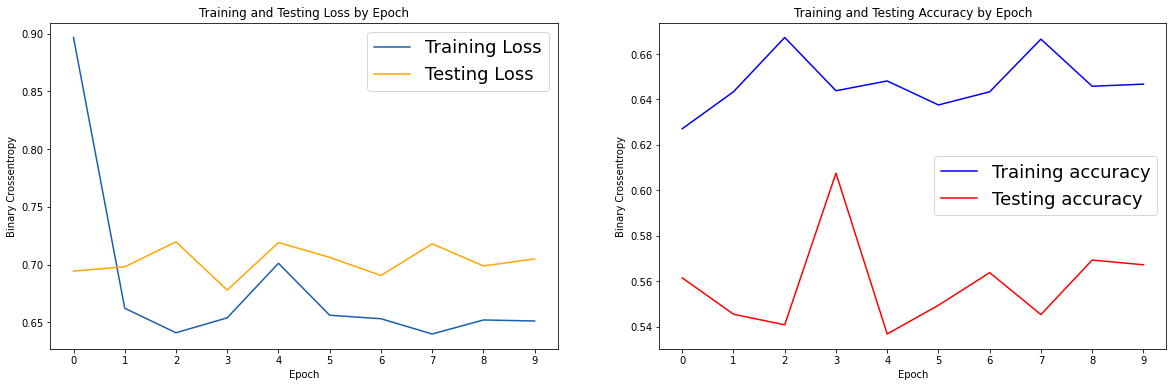

In [22]:
num_epochs = 10
cnn_model = create_model()
hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_meniscus, coronal_meniscus_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/5
1010/1010 [==============================] - 97s 95ms/step - loss: 0.8817 - accuracy: 0.6398 - val_loss: 0.6952 - val_accuracy: 0.5643

Epoch 00001: saving model to /content/drive/MyDrive/hst_amen/cp.ckpt
Epoch 2/5
1010/1010 [==============================] - 82s 81ms/step - loss: 0.6503 - accuracy: 0.6500 - val_loss: 0.7061 - val_accuracy: 0.5513

Epoch 00002: saving model to /content/drive/MyDrive/hst_amen/cp.ckpt
Epoch 3/5
1010/1010 [==============================] - 81s 80ms/step - loss: 0.6435 - accuracy: 0.6600 - val_loss: 0.7117 - val_accuracy: 0.5612

Epoch 00003: saving model to /content/drive/MyDrive/hst_amen/cp.ckpt
Epoch 4/5
1010/1010 [==============================] - 80s 79ms/step - loss: 0.6565 - accuracy: 0.6398 - val_loss: 0.6914 - val_accuracy: 0.5718

Epoch 00004: saving model to /content/drive/MyDrive/hst_amen/cp.ckpt
Epoch 5/5
1010/1010 [==============================] - 80s 80ms/step - loss: 0.6511 - accuracy: 0.6473 - val_loss: 0.6903 - val_accuracy: 0.

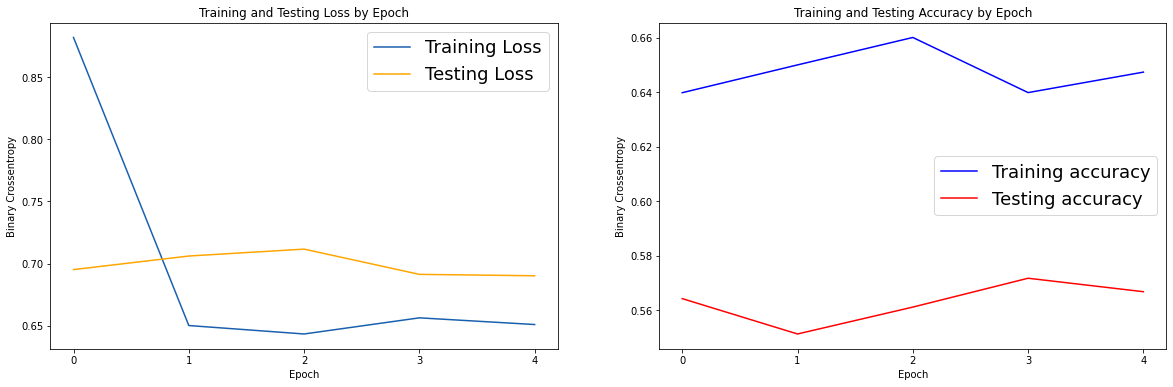

In [24]:
num_epochs = 5
cnn_model = create_model()
hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_meniscus, axial_meniscus_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_amen)

In [ ]:
num_epochs = 10
cnn_model = create_model()
hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_meniscus, sagittal_meniscus_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_smen)

**predictions for acl dataset**

In [ ]:
# num_epochs = 2
# hst_cacl = model_train(cnn_model, 'hst_cacl', num_epochs, coronal_acl, coronal_acl_val)
# plot_results(hst_cacl)

In [ ]:
# num_epochs = 2
# hst_aacl = model_train(cnn_model, 'hst_aacl', num_epochs, axial_acl, axial_acl_val)
# plot_results(hst_aacl)

In [ ]:
# num_epochs = 2
# hst_sacl = model_train(cnn_model, 'hst_sacl', num_epochs, sagittal_acl, sagittal_acl_val)
# plot_results(hst_sacl)

**ensembling meniscus dataset**

In [ ]:
# path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
path_dir = '/content/drive/MyDrive'

hst_cmen_cnn = cnn_model
hst_amen_cnn = cnn_model
hst_smen_cnn = cnn_model

hst_cmen_cnn.load_weights(f'{path_dir}/hst_cmen/cp.ckpt')
hst_amen_cnn.load_weights(f'{path_dir}/hst_amen/cp.ckpt')
hst_smen_cnn.load_weights(f'{path_dir}/hst_smen/cp.ckpt')

models = [hst_cmen_cnn, hst_amen_cnn, hst_smen_cnn]

In [ ]:
def ensemble(models):
#     models: List [training.Model], model_input: Tensor) -> training.Model
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)

    return y

In [ ]:
output = ensemble(models)

In [ ]:
output